In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

import requests
import json
import time
from geopy.geocoders import Nominatim
import re

from geopy import distance
from shapely.geometry import Point
from matplotlib import pyplot as plt

### Задача:

Прогноз продаж одной из популярных моделей [фичерфонов](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D1%87%D0%B5%D1%80%D1%84%D0%BE%D0%BD) (на картинке ниже пример похожего устройства) в салонах МегаФона
![](https://39.img.avito.st/640x480/8468720439.jpg)

### Исходные данные:

Датасет содержит следующие поля:

1. `point_id` - Индентификатор салона
2. `lon` - Долгота точки
3. `lat` - Широта точки
4. `target` - Значение таргета, усредненное за несколько месяцев и отнормированное

### Требования к решению и советы:

Ниже приведен список из нескольких важных пунктов, необходимых для решения задания. Выполнение каждого из пунктов влияет на итоговую оценку. Вы можете выполнить каждый из пунктов разными способами, самым лучшим будет считаться вариант, когда всё получение и обработка данных будут реализованы на Питоне (пример: вы можете скачать данные из OSM через интерфейс на сайте overpass-turbo или с помощью библиотек `overpass`/`requests`. Оба варианта будут зачтены, но больше баллов можно заработать во втором случае)



1. Салоны расположены в нескольких разных городах, вам необходимо **определить город для каждого салона** (это понадобится во многих частях задания). К этому есть разные подходы. Вы можете провести [обратное геокодирование](https://en.wikipedia.org/wiki/Reverse_geocoding) с помощью геокодера [Nominatim](https://nominatim.org/), доступного через библиотеку `geopy` примерно вот так:
```python
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)
```
В таком случае, вам придется обрабатывать полученную строку адреса, чтобы извлечь название города. Также вы можете скачать из OSM или найти в любом другом источнике границы административно территориальных границ России и пересечь с ними датасет с помощью `geopandas.sjoin` (этот вариант более надежный, но нужно будет разобраться с тем, как устроены границы АТД в OSM, обратите внимание на [этот тег](https://wiki.openstreetmap.org/wiki/Key:admin_level))

In [3]:
train = pd.read_csv('data/mf_geo_train.csv')

In [362]:
test = pd.read_csv('data/mf_geo_test.csv')
list(test)

['point_id', 'lon', 'lat', 'target']

In [88]:
list(train)
# lon - долгота
# lat - широта

['point_id', 'lon', 'lat', 'target']

In [363]:
# Создание нового столбца координат
y = train['lat'].astype('str')
x = train['lon'].astype('str')
s = y+", "+x
train['coordinate'] = s

In [364]:
# Создание нового столбца координат
y = test['lat'].astype('str')
x = test['lon'].astype('str')
s = y+", "+x
test['coordinate'] = s

In [365]:
overpass_url = "http://overpass-api.de/api/interpreter?data=[out:json];node(1);out;"

overpass_query1 = """  
[out:json];
area["name"="Россия"][admin_level=2];
(node["place"="city"](area););
out center; """
response1 = requests.get(overpass_url, 
                        params={'data': overpass_query1})
data1 = response1.json()

In [366]:
# Загружаем названия всех городов в России
Russia = pd.json_normalize(data1['elements'])
all_names = list(set(Russia['tags.name']))

In [8]:
# Чтобы не переписывать весь код, замена
#train = test.copy()

In [369]:
def function_name(j, x):
    name = None
    
    # Самые частые города
    
    if 'Москва' in x:
        print('Москва')
        return 'Москва'
        
    if 'Санкт-Петербург' in x:
        print('Санкт-Петербург')
        return 'Санкт-Петербург'
    
    for k in x:
        low_sum = sum(i.isupper() for i in k)
        
        if (k!='Россия') and  not k.isdigit() :
            if k in all_names:
                print(k)
                return k

In [359]:
def all_city_names_trainNew2(data):
    all_city = []
    
    for i in range(len(data)):
        coord = data['coordinate'][i]
        geolocator = Nominatim(user_agent=overpass_url)
        location = geolocator.reverse(coord)
        s = location.address
        x = s.split(', ')
        all_city.append(function_name(i, x))
        # Проверяем, что ничего не потерялось по дороге
        if len(all_city)<i:
            print(i)
            break
    return all_city

In [4]:
# Добавляем столбец названий городов
train['city'] = all_city_names_trainNew2(train)

In [ ]:
test['city'] = all_city_names_trainNew2(test)

In [372]:
# Сохранение, чтобы не пересчитываь
#train.to_csv('data/trainNew2')

In [ ]:
# Сохранение, чтобы не пересчитываь
#test.to_csv('data/testNew2')

In [374]:
# Можно практически перебрать все города

def all_city_names_trainNew1(data):
    
    all_city = []
    
    for i in range(len(train)):
        coord = train['coordinate'][i]
        geolocator = Nominatim(user_agent=overpass_url)
        location = geolocator.reverse(coord)
        s = location.address
        x = s.split(', ')
        n = len(x)//2
        # Чаще всего название города встречается во второй половине
        some = x[n-1:]
        # Можно напрямую проверять самые частые города
        if 'Москва' in x:
            all_city.append('Москва')
            #print(i, ' ', 'Москва')
        elif 'Санкт-Петербург' in x:
            all_city.append('Санкт-Петербург')
            #print(i, ' ', 'Санкт-Петербург')
        elif 'Нижний Новгород' in x:
            all_city.append('Нижний Новгород')
        elif 'Екатеринбург' in x:
            all_city.append('Екатеринбург')
        elif 'Самара' in x:
            all_city.append('Самара')
        elif 'Уфа' in x:
            all_city.append('Уфа')
            #print(i, ' ', 'Санкт-Петербург')
        else:     
            for k in some:
                l = k.split(' ')
                # В случае города чаще всего он состоит из одного слова
                # Исключаем цифры и латинские буквы
                if (len(l)== 1) and (l[0]!='Россия') and not (re.search(r'[^a-zA-Zа-яА-Я-]',l[0] )):
                    all_city.append(l[0])
                    print(i, ' ', l[0])
                    break
        if len(all_city)<i:
            print(i)
    return all_city

In [13]:
train['city'] = all_city_names_trainNew1(train)

In [ ]:
test['city'] = all_city_names_trainNew1(test)

In [ ]:
# Сохранение, чтобы не пересчитываь
#train.to_csv('data/trainNew1')

In [18]:
# Сохранение, чтобы не пересчитываь
#test.to_csv('data/testNew1')

In [377]:
trainNew1 = pd.read_csv('data/trainNew1').drop('Unnamed: 0', axis = 1)
trainNew2 = pd.read_csv('data/trainNew2').drop('Unnamed: 0', axis = 1) # api

In [26]:
#trainNew1 = pd.read_csv('data/testNew1').drop('Unnamed: 0', axis = 1)
#trainNew2 = pd.read_csv('data/testNew2').drop('Unnamed: 0', axis = 1) # api

In [162]:
# Сравним теперь различия

In [378]:
x = ((trainNew1['city']!=trainNew2['city'])*1)
for j in range(len(x)):
    if x[j] == 1:
        print(j)
        print(trainNew1['city'][j], ' ', trainNew2['city'][j])

137
Казань   Калуга


In [136]:
# Посмотрим с помощью api, какой ответ правильный.
overpass_url = "http://overpass-api.de/api/interpreter?data=[out:json];node(1);out;"

overpass_query2 = """  
[out:json][timeout:25];
// gather results by freeExec
(
  is_in( {}) -> .b;
  
  (way(pivot.b)["place"="city"];
   rel(pivot.b)["place"="city"];
   )-> .c;
  
);
.c out body;
>;
out skel qt; """.format(coord)

coord = trainNew1['coordinate'][137]
response2 = requests.get(overpass_url, 
                        params={'data': overpass_query2})
data2 = response2.json()

In [137]:
data2['elements'][0]['tags']['name']

'Казань'

In [376]:
coord = trainNew1['coordinate'][137]
geolocator = Nominatim(user_agent=overpass_url)
location = geolocator.reverse(coord)
s = location.address
s

'14, улица Вишневского, Калуга, Вахитовский район, Казань, городской округ Казань, Татарстан, Приволжский федеральный округ, 420024, Россия'


2. **Используйте данные OSM**: подумайте, какие объекты могут влиять на продажи фичерфонов. Гипотеза: такие телефоны покупают люди, приезжающие в город или страну ненадолго, чтобы вставить туда отдельную симкарту для роуминга. Можно попробовать использовать местоположения железнодорожных вокзалов (изучите [этот тег](https://wiki.openstreetmap.org/wiki/Tag:railway%3Dstation)). Необходимо использовать хотя бы 5 разных типов объектов из OSM. Скорее всего, вам придется качать данные OSM отдельно для разных городов (см. пример для Нью-Йорка из лекции)


In [282]:
trainNew1 = pd.read_csv('data/trainNew1').drop('Unnamed: 0', axis = 1) # Nominatim
trainNew2 = pd.read_csv('data/trainNew2').drop('Unnamed: 0', axis = 1) # api

In [32]:
#trainNew1 = pd.read_csv('data/testNew1').drop('Unnamed: 0', axis = 1) # Nominatim
#trainNew2 = pd.read_csv('data/testNew2').drop('Unnamed: 0', axis = 1) # api

In [270]:
# Создадим новую характеристику размера города - центр города.
def string_req_center(coord):
    overpass_query = """  
    [out:json];
    area[name="{}"];
    (node["place"="city"](area););
    out center; """.format(coord)
    
    return overpass_query

In [ ]:
towns = list(set(trainNew1['city']))
len(towns)

In [379]:
overpass_url = "http://overpass-api.de/api/interpreter?data=[out:json];node(1);out;"

dict_name = {}

for i in range(len(towns)):
    print('sleep', i)
    city = towns[i]
    
    response = requests.get(overpass_url, 
                        params={'data': string_req_center(city)})
    data = response.json()
        
    if len(data['elements']) == 0:
        dict_name[city] = 0
        print(city, ' ', 0)
    else:
        
        frame = pd.json_normalize(data['elements'])
        center = (float(frame[frame['tags.name'] == city]['lat']) , float(frame[frame['tags.name'] == city]['lon']))

        dict_name[towns[i]]=center
        print(city, ' ', center)
        time.sleep(3)

sleep 0
Ростов-на-Дону   (47.2213858, 39.7114196)
sleep 1
Санкт-Петербург   (59.938732, 30.316229)
sleep 2
Красноярск   (56.0090968, 92.8725147)
sleep 3
Нижний Новгород   (56.328571, 44.003506)
sleep 4
Москва   (55.7504461, 37.6174943)
sleep 5
Екатеринбург   (56.839104, 60.60825)
sleep 6
Казань   (55.7823547, 49.1242266)
sleep 7
Новосибирск   (55.0282171, 82.9234509)
sleep 8
Уфа   (54.7261409, 55.947499)
sleep 9
Балашиха   (55.8036225, 37.9646488)
sleep 10
Самара   (53.198627, 50.113987)


In [287]:
x_lat = []
x_lon = []
for name in trainNew1['city']:
    x_lat.append(str(dict_name[name][0]))
    x_lon.append(str(dict_name[name][1]) )
trainNew1['lat_center'] = x_lat
trainNew1['lon_center'] = x_lon

In [152]:
# Создадим новую характеристику размера города - количество наземных железнодорожных станций.
def string_req_town(coord):
    overpass_query = """  
    [out:json];
    area[name="{}"];
    nwr(area)[railway=station];
    out; """.format(coord)
    
    return overpass_query

In [153]:
overpass_url = "http://overpass-api.de/api/interpreter?data=[out:json];node(1);out;"

towns = list(set(trainNew1['city']))
dict_rail = {}

for i in range(len(towns)):
    print('sleep', i)
    time.sleep(10)
    city = towns[i]
    
    response = requests.get(overpass_url, 
                        params={'data': string_req_town(city)})
    data = response.json()
        
    if len(data['elements']) == 0:
        dict_rail[city]=0
        print(city, ' ', 0)
    else:
        dff = pd.json_normalize(data['elements'])
        if 'tags.layer' in list(dff):
            dff['tags.layer']=dff['tags.layer'].fillna(0)
            n = len(dff[dff['tags.layer']==0]['tags.name'])
        else:
            n = len(dff)
        dict_rail[towns[i]]=n
        print(city, ' ', n)

sleep 0
Балашиха   2
sleep 1
Санкт-Петербург   57
sleep 2
Самара   20
sleep 3
Уфа   11
sleep 4
Ростов-на-Дону   12
sleep 5
Новосибирск   14
sleep 6
Казань   23
sleep 7
Нижний Новгород   25
sleep 8
Москва   96
sleep 9
Красноярск   12
sleep 10
Екатеринбург   18


In [154]:
x = []
for name in trainNew1['city']:
    x.append(dict_rail[name])
trainNew1['Number_of_rs'] = x

In [155]:
# Создадим новую характеристику размера города - количество отелей и хостелов.
def string_req_hotel(coord):
    overpass_query = """  
    [out:json];
    area[name="{}"];
    nwr(area)[tourism=hotel];
    out; """.format(coord)
    
    return overpass_query

def string_req_hostel(coord):
    overpass_query = """  
    [out:json];
    area[name="{}"];
    nwr(area)[tourism=hostel];
    out; """.format(coord)
    
    return overpass_query

def string_req_guest(coord):
    overpass_query = """  
    [out:json];
    area[name="{}"];
    nwr(area)[tourism=guest_house];
    out; """.format(coord)
    
    return overpass_query

In [158]:
dict_rail = {}
begin = 0

In [164]:
overpass_url = "http://overpass-api.de/api/interpreter?data=[out:json];node(1);out;"

towns = list(set(trainNew1['city']))

for i in range(begin, len(towns)):
    print('sleep', i)
    
    
    city = towns[i]
    
    my_sum = 0
    
    response = requests.get(overpass_url, 
                        params={'data': string_req_hotel(city)})
    try:
        data = response.json()
    except:
        begin = i
        break
        
    if len(data['elements']) == 0:
        my_sum += 0
        print(city, ' ', 0)
    else:
        n = len(data['elements'])
        my_sum +=n
    
    time.sleep(5)
    
    response = requests.get(overpass_url, 
                        params={'data': string_req_hostel(city)})
    try:
        data = response.json()
    except:
        begin = i
        break
        
    if len(data['elements']) == 0:
        my_sum += 0
        print(city, ' ', 0)
    else:
        n = len(data['elements'])
        my_sum +=n
    
    time.sleep(5)
    
    response = requests.get(overpass_url, 
                        params={'data': string_req_guest(city)})
    
    try:
        data = response.json()
    except:
        begin = i
        break
        
    if len(data['elements']) == 0:
        my_sum += 0
        print(city, ' ', 0)
    else:
        n = len(data['elements'])
        my_sum +=n
    
    dict_rail[towns[i]]=my_sum
    print(city, ' ', my_sum)
    time.sleep(10)

sleep 9
Красноярск   78
sleep 10
Екатеринбург   130


In [165]:
x = []
for name in trainNew1['city']:
    x.append(dict_rail[name])
trainNew1['Number_of_tourism'] = x

In [48]:
#trainNew1.to_csv('data/testDf')

In [166]:
#trainNew1.to_csv('data/trainDf')

3. **Используйте разные способы генерации признаков**: описать положение салона МегаФона относительно станций метро можно разными способами - найти ***расстояние до ближайшей станции***, или же посчитать, сколько станций попадает в ***500 метровую буферную зону*** вокруг салона. Такие признаки будут нести разную информацию. Так же попробуйте поэкспериментировать с размерами буферных зон (представьте, что значат в реальности радиусы 100, 500, 1000 метров). Попробуйте посчитать расстояние до центра города, до других объектов.

In [63]:
df = pd.read_csv('data/trainDf').drop('Unnamed: 0', axis = 1)

In [54]:
#df = pd.read_csv('data/testDf').drop('Unnamed: 0', axis = 1)

In [169]:
# Приезжие могут купить телефон на станции
# Посчитаем количество станций в окрестности 600 метров координаты
def str_req(city, coord):
    overpass_query = """
    [out:json];
    area[name="{}"];
    nwr(area)[railway=station](around:600.0,{});
    out;
    """.format(city, coord)
    
    return overpass_query

In [170]:
begin = 0
number = []

In [5]:
# Достаточно долгий, но простой способ это сделать через запрос.
overpass_url = "http://overpass-api.de/api/interpreter?data=[out:json];node(1);out;"


for i in range(begin, len(df)):
    
    coord = df['coordinate'][i]
    city = df['city'][i]
    
    print('sleep', i)
    
    response = requests.get(overpass_url, 
                        params={'data': str_req(city, coord)})
    try:
        data = response.json()
    except:
        begin = i
        break
    
    if len(data['elements']) == 0:
        n = 0
    else:
        n = len(data['elements'])
        
    number.append(n)
    print(coord, ' ', city, ' ', n)
    time.sleep(10)

In [177]:
df['num_rail'] = number

In [178]:
#df.to_csv('data/trainDf')

In [58]:
#df.to_csv('data/testDf')

In [179]:
# Приезжие могут купить телефон у гостиницы, поэтому проверим эти точки тоже
def str_hotel(city, coord):
    overpass_query = """
    [out:json];
    area[name="{}"];
    nwr(area)[tourism=hotel](around:600.0,{});
    out;
    """.format(city, coord)
    
    return overpass_query

def str_hostel(city, coord):
    overpass_query = """
    [out:json];
    area[name="{}"];
    nwr(area)[tourism=hostel](around:600.0,{});
    out;
    """.format(city, coord)
    
    return overpass_query

def str_guest(city, coord):
    overpass_query = """
    [out:json];
    area[name="{}"];
    nwr(area)[tourism=guest_house](around:600.0,{});
    out;
    """.format(city, coord)
    
    return overpass_query

In [180]:
begin = 0
number = []

In [6]:
overpass_url = "http://overpass-api.de/api/interpreter?data=[out:json];node(1);out;"


for i in range(begin, len(df)):
    
    
    coord = df['coordinate'][i]
    city = df['city'][i]
    my_sum = 0
    
    print('sleep', i)
    
    response = requests.get(overpass_url, 
                        params={'data': str_hotel(city, coord)})
    try:
        data = response.json()
    except:
        begin = i
        break
    
    if len(data['elements']) == 0:
        n = 0
    else:
        n = len(data['elements'])
    my_sum+=n
    
    time.sleep(5)    
    response = requests.get(overpass_url, 
                        params={'data': str_hostel(city, coord)})
    
    try:
        data = response.json()
    except:
        begin = i
        break
    
    if len(data['elements']) == 0:
        n = 0
    else:
        n = len(data['elements'])
    my_sum+=n
    
    time.sleep(5)    
    response = requests.get(overpass_url, 
                        params={'data': str_guest(city, coord)})
    
    try:
        data = response.json()
    except:
        begin = i
        break
    
    if len(data['elements']) == 0:
        n = 0
    else:
        n = len(data['elements'])
    my_sum+=n
    
    
    number.append(my_sum)
    print(coord, ' ', city, ' ', my_sum)
    time.sleep(10)

In [185]:
df['num_tourism'] = number

In [186]:
#df.to_csv('data/trainDf')

In [70]:
#df.to_csv('data/testDf')

In [2]:
# Можно посмотреть количество автомое и автосервисов. Логика в том, что при такой работе кнопочный телефон удобнее.
# Ну или там махинации какие.
def str_wash(city, coord):
    overpass_query = """
    [out:json];
    area[name="{}"];
    nwr(area)[amenity=car_wash](around:600.0,{});
    out;
    """.format(city, coord)
    
    return overpass_query

def str_repair(city, coord):
    overpass_query = """
    [out:json];
    area[name="{}"];
    nwr(area)[shop=car_repair](around:600.0,{});
    out;
    """.format(city, coord)
    
    return overpass_query

In [3]:
begin = 0
number = []

In [7]:
overpass_url = "http://overpass-api.de/api/interpreter?data=[out:json];node(1);out;"


for i in range(begin, len(df)):
    
    
    coord = df['coordinate'][i]
    city = df['city'][i]
    my_sum = 0
    
    print('sleep', i)
    
    response = requests.get(overpass_url, 
                        params={'data': str_wash(city, coord)})
    
    try:
        data = response.json()
    except:
        begin = i
        break
    
    if len(data['elements']) == 0:
        n = 0
    else:
        n = len(data['elements'])
    my_sum+=n
    
    time.sleep(5)    
    response = requests.get(overpass_url, 
                        params={'data': str_repair(city, coord)})
    
    try:
        data = response.json()
    except:
        begin = i
        break
    
    if len(data['elements']) == 0:
        n = 0
    else:
        n = len(data['elements'])
    my_sum+=n
    
    
    number.append(my_sum)
    print(coord, ' ', city, ' ', my_sum)
    time.sleep(5)

In [7]:
df['num_car_rep'] = number

In [8]:
#df.to_csv('data/trainDf')

In [79]:
#df.to_csv('data/testDf')

In [55]:
# Приезжие могут купить телефон там, где хотят взять автомобиль
def str_rental(city, coord):
    overpass_query = """
    [out:json];
    area[name="{}"];
    nwr(area)[amenity=car_rental](around:600.0,{});
    out;
    """.format(city, coord)
    
    return overpass_query

def str_sharing(city, coord):
    overpass_query = """
    [out:json];
    area[name="{}"];
    nwr(area)[amenity=car_sharing](around:600.0,{});
    out;
    """.format(city, coord)
    
    return overpass_query

In [56]:
begin = 0
number = []

In [59]:
overpass_url = "http://overpass-api.de/api/interpreter?data=[out:json];node(1);out;"


for i in range(begin, len(df)):
    
    
    coord = df['coordinate'][i]
    city = df['city'][i]
    my_sum = 0
    
    
    print('sleep', i)
    
    response = requests.get(overpass_url, 
                        params={'data': str_rental(city, coord)})
    
    try:
        data = response.json()
    except:
        begin = i
        break
    
    if len(data['elements']) == 0:
        n = 0
    else:
        n = len(data['elements'])
    my_sum+=n
    
    time.sleep(5)    
    response = requests.get(overpass_url, 
                        params={'data': str_sharing(city, coord)})
    
    try:
        data = response.json()
    except:
        begin = i
        break
    
    if len(data['elements']) == 0:
        n = 0
    else:
        n = len(data['elements'])
    my_sum+=n
    
    
    number.append(my_sum)
    print(coord, ' ', city, ' ', my_sum)
    time.sleep(10)

sleep 87
55.865531, 37.704889   Москва   0
sleep 88
55.77962, 37.665634   Москва   0
sleep 89
55.97888100000001, 37.171523   Москва   0
sleep 90
59.998265, 30.298459   Санкт-Петербург   0
sleep 91
55.02964300000001, 82.919046   Новосибирск   0
sleep 92
53.236437, 50.190779   Самара   0
sleep 93
55.776347, 37.655172   Москва   0
sleep 94
55.659195, 37.756084   Москва   0
sleep 95
55.995629, 92.950129   Красноярск   0
sleep 96
59.851439, 30.271218   Санкт-Петербург   0
sleep 97
59.926476, 30.318213   Санкт-Петербург   0
sleep 98
60.067586, 30.334946   Санкт-Петербург   0
sleep 99
54.765098, 56.064899   Уфа   0
sleep 100
55.72345600000001, 37.565332   Москва   0
sleep 101
55.618593, 37.506621   Москва   0
sleep 102
60.049792, 30.353777   Санкт-Петербург   0
sleep 103
56.116262, 92.928927   Красноярск   0
sleep 104
56.023697, 93.015993   Красноярск   0
sleep 105
59.871149, 30.381172   Санкт-Петербург   0
sleep 106
59.94211, 30.279244   Санкт-Петербург   0


In [60]:
df['num_car_shar'] = number
#108 133 81 193 237 239 256 317 343 373 380 411
# r   r  s   r   r  r    r   r  r    r   r   r

In [35]:
i = 411
coord = df['coordinate'][i]
city = df['city'][i]

response = requests.get(overpass_url, 
                        params={'data': str_rental(city, coord)})

data = response.json()
print(df['num_car_shar'][i])
data

1


{'version': 0.6,
 'generator': 'Overpass API 0.7.56.7 b85c4387',
 'osm3s': {'timestamp_osm_base': '2020-12-03T09:10:02Z',
  'timestamp_areas_base': '2020-12-03T08:55:03Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': [{'type': 'node',
   'id': 4929838676,
   'lat': 59.924827,
   'lon': 30.3577378,
   'tags': {'amenity': 'car_rental',
    'contact:vk': 'https://vk.com/luxeavtocom',
    'name': 'ЛюксАвто',
    'opening_hours': '10:00-13:00,14:00-19:00',
    'website': 'http://luxeavto-spb.ru/'}}]}

In [12]:
#df.to_csv('data/trainDf')

In [61]:
#df.to_csv('data/testDf')

In [36]:
def str_food(city, coord):
    overpass_query = """
    [out:json];
    area[name="{}"];
    nwr(area)[amenity=fast_food](around:600.0,{});
    out;
    """.format(city, coord)
    
    return overpass_query

In [37]:
begin = 0
number = []

In [41]:
overpass_url = "http://overpass-api.de/api/interpreter?data=[out:json];node(1);out;"


for i in range(begin, len(df)):
    
    
    coord = df['coordinate'][i]
    city = df['city'][i]
    my_sum = 0
    
    
    print('sleep', i)
    
    response = requests.get(overpass_url, 
                        params={'data': str_food(city, coord)})
    
    try:
        data = response.json()
    except:
        begin = i
        break
    
    if len(data['elements']) == 0:
        n = 0
    else:
        n = len(data['elements'])
    my_sum+=n
    
    
    number.append(my_sum)
    print(coord, ' ', city, ' ', my_sum)
    time.sleep(5)

sleep 413
59.83404, 30.204863   Санкт-Петербург   3
sleep 414
55.613216, 37.743868   Москва   6
sleep 415
56.869249, 60.554713   Екатеринбург   0
sleep 416
53.187213, 50.121798   Самара   4
sleep 417
55.870102, 37.664267   Москва   6
sleep 418
55.056951, 82.976488   Новосибирск   3
sleep 419
59.931738, 30.362055   Санкт-Петербург   68
sleep 420
55.740664, 37.628765   Москва   14
sleep 421
55.794233, 37.586825   Москва   26
sleep 422
55.77291, 37.67879   Москва   28
sleep 423
55.61964, 37.75213   Москва   4
sleep 424
55.78295, 37.70577   Москва   15


In [42]:
df['num_food'] = number

In [43]:
#df.to_csv('data/trainDf')

In [110]:
#df.to_csv('data/testDf')

In [44]:
def str_attraction(city, coord):
    overpass_query = """
    [out:json];
    area[name="{}"];
    nwr(area)[tourism=attraction](around:600.0,{});
    out;
    """.format(city, coord)
    
    return overpass_query

In [45]:
begin = 0
number = []

In [51]:
overpass_url = "http://overpass-api.de/api/interpreter?data=[out:json];node(1);out;"

for i in range(begin, len(df)):
    
    
    coord = df['coordinate'][i]
    city = df['city'][i]
    my_sum = 0
    
    print('sleep', i)
    
    response = requests.get(overpass_url, 
                        params={'data': str_attraction(city, coord)})
    
    try:
        data = response.json()
    except:
        begin = i
        break
    
    if len(data['elements']) == 0:
        n = 0
    else:
        n = len(data['elements'])
    my_sum+=n
    
    
    number.append(my_sum)
    print(coord, ' ', city, ' ', my_sum)
    time.sleep(10)

sleep 403
56.86539200000001, 60.5324   Екатеринбург   0
sleep 404
53.25928100000001, 50.225666   Самара   0
sleep 405
55.801912, 37.531968   Москва   1
sleep 406
55.75524, 37.660183   Москва   2
sleep 407
59.850762, 30.268333   Санкт-Петербург   0
sleep 408
55.717847, 37.681473   Москва   3
sleep 409
59.867776, 30.260932   Санкт-Петербург   1
sleep 410
55.85578, 37.477381   Москва   0
sleep 411
59.921134, 30.355126   Санкт-Петербург   1
sleep 412
59.833301, 30.391599   Санкт-Петербург   0
sleep 413
59.83404, 30.204863   Санкт-Петербург   0
sleep 414
55.613216, 37.743868   Москва   0
sleep 415
56.869249, 60.554713   Екатеринбург   0
sleep 416
53.187213, 50.121798   Самара   1
sleep 417
55.870102, 37.664267   Москва   0
sleep 418
55.056951, 82.976488   Новосибирск   0
sleep 419
59.931738, 30.362055   Санкт-Петербург   4
sleep 420
55.740664, 37.628765   Москва   2
sleep 421
55.794233, 37.586825   Москва   0
sleep 422
55.77291, 37.67879   Москва   2
sleep 423
55.61964, 37.75213   Москва   

In [52]:
df['num_attraction'] = number

In [53]:
#df.to_csv('data/trainDf')

In [130]:
#df.to_csv('data/testDf')

Можно вычислить расстояние от цента с помощью координат, которые были найдены ранее.

In [380]:
#df = pd.read_csv('data/trainDf').drop('Unnamed: 0', axis = 1)

In [ ]:
#df = pd.read_csv('data/testDf').drop('Unnamed: 0', axis = 1)

In [66]:
# Для начала посчитаем расстояние от центра.
# Теперь добавим признаки, характеризующие расстояния.
from geopy import distance
dist = []
for i in range(len(df)):
    a = (float(df['lat'][i]), float(df['lon'][i]))
    b = (float(df['lat_center'][i]), float(df['lon_center'][i]))
    d = distance.geodesic(a, b).km
    dist.append(d)

In [67]:
df['dist_center'] = dist

In [69]:
#df.to_csv('data/trainDf')

In [ ]:
#df.to_csv('data/testDf')

Выгрузим данные по rail, hotel, hostel, repair, rental, food, attraction отдельно для каждого города, а не по окрестности вокруг координаты. Это очень долго.  
Таким образом тоже можно посчитать окрестность вокруг магазина на расстоянии 600 метров, однако из-за того, что у многих элементов отсутствуют указанные координаты, значения могут отличаться.

In [2]:
df = pd.read_csv('data/trainDf').drop('Unnamed: 0', axis = 1)

In [ ]:
#df = pd.read_csv('data/testDf').drop('Unnamed: 0', axis = 1)

In [3]:
towns = list(set(df['city']))
overpass_url = "http://overpass-api.de/api/interpreter?data=[out:json];node(1);out;"

In [4]:
len(towns)

11

In [24]:

# Приезжие могут купить телефон на станции

overpass_rail = """
[out:json];
area[name="{}"];
nwr(area)[railway=station];
out;
"""

# Приезжие могут купить телефон у гостиницы, поэтому проверим эти точки тоже

overpass_hotel = """
[out:json];
area[name="{}"];
nwr(area)[tourism=hotel];
out;
"""

overpass_guest = """
[out:json];
area[name="{}"];
nwr(area)[tourism=guest_house];
out;
"""

# Отдельно можно рассмотреть хостулы, так как их можно отнести к более низкому ценовому сегменту
overpass_hostel = """
[out:json];
area[name="{}"];
nwr(area)[tourism=hostel];
out;
"""

# Посмотрим так же автомойки и починку автомобилей. Рабочим может быть удобнее пользоваться кнопочными телефонами
# Рассчитываем на текучку кадров и нечистые махинации :)
overpass_wash = """
[out:json];
area[name="{}"];
nwr(area)[shop=car_wash];
out;
"""

overpass_repair = """
[out:json];
area[name="{}"];
nwr(area)[shop=car_repair];
out;
"""

# Есть всего несколько точек, где можно взять автомобиль напрокат. Это актуально для приезжих.
overpass_rental = """
[out:json];
area[name="{}"];
nwr(area)[amenity=car_rental];
out;
"""

overpass_sharing = """
[out:json];
area[name="{}"];
nwr(area)[amenity=car_sharing];
out;
"""
# Там где много еды - оживленный район и много рабочих.
overpass_food = """
[out:json];
area[name="{}"];
nwr(area)[amenity=fast_food];
out;
"""
# Достопримечательности - популярное место у туристов.
overpass_attraction = """
[out:json];
area[name="{}"];
nwr(area)[tourism=attraction];
out;
"""   

#aeroway=aerodrome

overpass_air = """
[out:json];
area[name="{}"];
nwr(area)[aeroway=aerodrome];
out;
"""   

In [5]:
def Response_str(city, overpass_str, overpass_url):
    
    response = requests.get(overpass_url, 
                        params={'data': overpass_str.format(city)})
        
    try:
        data = response.json()
    except:
        print('sleep')
        time.sleep(10)
            
        response = requests.get(overpass_url, 
                        params={'data': overpass_str.format(city)})
        data = response.json()
            
    if len(data['elements']) == 0:
        dff = pd.DataFrame(data = [])
    else:
        dff = pd.json_normalize(data['elements'])
    return dff

In [6]:

def Return_dict_amenity (towns, overpass_str1 = '', overpass_str2 = ''):
    
    overpass_url = "http://overpass-api.de/api/interpreter?data=[out:json];node(1);out;"
    
    dict_x = {}

    for i in range(len(towns)):
        print('sleep', i)
        city = towns[i]
        my_sum = 0
        
        if (len(overpass_str1)!=0 and  len(overpass_str2)!=0):
            dff1 = Response_str(city, overpass_str1, overpass_url)
            dff2 = Response_str(city, overpass_str2, overpass_url)
            dff = pd.concat([dff1, dff2], axis = 0)
            columns = dff.columns
            dff = pd.concat([dff1, dff2], axis = 0, ignore_index=True)
            dff.columns = columns
        elif len(overpass_str1)!=0:
            dff = Response_str(city, overpass_str1, overpass_url)
        elif len(overpass_str2)!=0:
            dff = Response_str(city, overpass_str2, overpass_url)
        
        dict_x[towns[i]]= dff
        
        print(city, ' ', len(dff))
        time.sleep(5)
    return dict_x

In [7]:
dict_rail = Return_dict_amenity (towns,  overpass_rail)

sleep 0
Екатеринбург   27
sleep 1
Самара   20
sleep 2
sleep
Санкт-Петербург   124
sleep 3
Уфа   11
sleep 4
sleep
Красноярск   12
sleep 5
Ростов-на-Дону   12
sleep 6
sleep
Москва   304
sleep 7
Балашиха   2
sleep 8
Казань   23
sleep 9
Нижний Новгород   25
sleep 10
Новосибирск   37


In [10]:
dict_hotel = Return_dict_amenity (towns,  overpass_hotel, overpass_guest)

sleep 0
sleep
sleep
Екатеринбург   102
sleep 1
Самара   69
sleep 2
sleep
Санкт-Петербург   853
sleep 3
Уфа   32
sleep 4
Красноярск   56
sleep 5
Ростов-на-Дону   83
sleep 6
Москва   705
sleep 7
sleep
Балашиха   20
sleep 8
sleep
Казань   127
sleep 9
Нижний Новгород   103
sleep 10
Новосибирск   65


In [11]:
dict_hostel = Return_dict_amenity (towns,  overpass_hostel)

sleep 0
Екатеринбург   28
sleep 1
Самара   6
sleep 2
Санкт-Петербург   218
sleep 3
Уфа   9
sleep 4
Красноярск   22
sleep 5
Ростов-на-Дону   8
sleep 6
Москва   324
sleep 7
Балашиха   1
sleep 8
Казань   31
sleep 9
Нижний Новгород   17
sleep 10
Новосибирск   18


In [12]:
dict_repair = Return_dict_amenity (towns,  overpass_repair, overpass_wash)

sleep 0
Екатеринбург   273
sleep 1
Самара   95
sleep 2
Санкт-Петербург   903
sleep 3
Уфа   99
sleep 4
Красноярск   72
sleep 5
Ростов-на-Дону   98
sleep 6
Москва   1398
sleep 7
Балашиха   147
sleep 8
Казань   192
sleep 9
Нижний Новгород   193
sleep 10
Новосибирск   255


In [13]:
dict_rental = Return_dict_amenity (towns,  overpass_rental, overpass_sharing)

sleep 0
Екатеринбург   4
sleep 1
Самара   1
sleep 2
Санкт-Петербург   19
sleep 3
Уфа   0
sleep 4
Красноярск   3
sleep 5
Ростов-на-Дону   2
sleep 6
Москва   23
sleep 7
Балашиха   0
sleep 8
Казань   2
sleep 9
Нижний Новгород   1
sleep 10
Новосибирск   9


In [14]:
dict_food = Return_dict_amenity(towns,  overpass_food)

sleep 0
Екатеринбург   306
sleep 1
Самара   68
sleep 2
Санкт-Петербург   1772
sleep 3
Уфа   73
sleep 4
Красноярск   54
sleep 5
Ростов-на-Дону   77
sleep 6
Москва   2742
sleep 7
Балашиха   110
sleep 8
Казань   209
sleep 9
Нижний Новгород   140
sleep 10
Новосибирск   198


In [15]:
dict_attraction = Return_dict_amenity(towns,  overpass_attraction)

sleep 0
Екатеринбург   52
sleep 1
Самара   17
sleep 2
Санкт-Петербург   614
sleep 3
Уфа   21
sleep 4
Красноярск   9
sleep 5
Ростов-на-Дону   107
sleep 6
Москва   748
sleep 7
Балашиха   19
sleep 8
Казань   86
sleep 9
Нижний Новгород   486
sleep 10
Новосибирск   110


In [25]:
dict_air = Return_dict_amenity(towns,  overpass_air)

sleep 0
Екатеринбург   1
sleep 1
Самара   4
sleep 2
Санкт-Петербург   7
sleep 3
Уфа   2
sleep 4
Красноярск   0
sleep 5
Ростов-на-Дону   2
sleep 6
Москва   2
sleep 7
Балашиха   1
sleep 8
Казань   2
sleep 9
Нижний Новгород   2
sleep 10
Новосибирск   2


In [41]:
def Dist_Search_for(df, dict_x):
    
    dist = []
    buf = []
    B = 0.3
    
    for i in range(len(df)):
        
        buffer = 0
        
        a = (float(df['lat'][i]), float(df['lon'][i]))
        city = df['city'][i]
        flag= 0
        
        dff = dict_x[city]
        
        if ('lat' in list(dff)) and ('lon' in list(dff)):
            df_new = dff[['lat', 'lon']].copy()
            df_new = df_new.dropna()
        else:
            min_dist = -1
            dist.append(min_dist)
            buf.append(buffer)
            continue
        

        for j in df_new.index:
        
            b = (float(df_new['lat'][j]), float(df_new['lon'][j]) )
            d = distance.geodesic(a, b).km
            
            if flag==0:
                min_dist = d
                flag = 1
            elif min_dist > d:
                min_dist = d
            
            if d<= B:
                buffer+=1
        
        dist.append(min_dist)
        buf.append(buffer)
        print(i, ' ', city, ' ', min_dist, ' ', buffer)
        
    return dist, buf

In [8]:
dist_rail, buf_rail = Dist_Search_for(df, dict_rail)

In [9]:
dist_hotel, buf_hotel = Dist_Search_for(df, dict_hotel)

In [10]:
dist_hostel, buf_hostel = Dist_Search_for(df, dict_hostel)

In [11]:
dist_repair, buf_repair = Dist_Search_for(df, dict_repair)

In [12]:
dist_rental, buf_rental = Dist_Search_for(df, dict_rental)

In [13]:
dist_food, buf_food = Dist_Search_for(df, dict_food)

In [14]:
dist_attraction, buf_attraction = Dist_Search_for(df, dict_attraction)

In [15]:
dist_air, buf_air = Dist_Search_for(df, dict_air)

In [57]:
df['dist_rail'] = dist_rail
df['dist_hotel']  = dist_hotel
df['dist_hostel'] = dist_hostel
df['dist_repair'] = dist_repair
df['dist_rental'] = dist_rental
df['dist_food'] = dist_food
df['dist_attraction'] = dist_attraction
df['dist_air'] = dist_air

In [58]:
df['300_buf_rail'] = buf_rail
df['300_buf_hotel']  = buf_hotel
df['300_buf_hostel'] = buf_hostel
df['300_buf_repair'] = buf_repair
df['300_buf_rental'] = buf_rental
df['300_buf_food'] = buf_food
df['300_buf_attraction'] = buf_attraction
df['300_buf_air'] = buf_air

In [47]:
#df.to_csv('data/trainDf')

In [59]:
#df.to_csv('data/testDf')

4. **Сделайте визуализации**: постройте 2-3 карты для какого нибудь из городов - как распределен в пространстве таргет, где находятся объекты, полученные вами из OSM. Можете использовать любой инструмент - обычный `plot()`, `folium`, `keplergl`. Если выберете Кеплер, обязательно сохраните в файл конфиг карты, чтобы ее можно было воспроизвести. Сделать это можно вот так:

```python
import json
json_data = kepler_map.config
with open('kepler_config.json', 'w') as outfile:
    json.dump(json_data, outfile)
```


In [2]:
#df = pd.read_csv('data/trainDf').drop('Unnamed: 0', axis = 1)

In [48]:
#df = pd.read_csv('data/testDf').drop('Unnamed: 0', axis = 1)

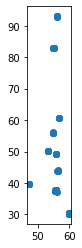

In [337]:
from shapely.geometry import Point
import numpy as np

x = df['lat'].astype(float)
y = df['lon'].astype(float)

p = []
for i in range(len(x)):
    p.append(Point(x[i],y[i]))
    
empire = gpd.GeoDataFrame( geometry=p, crs={'init': 'epsg:4326'})
empire.plot();

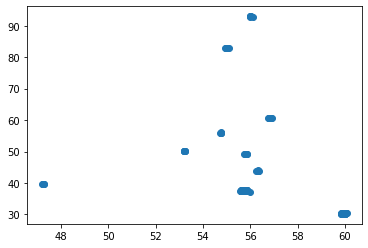

In [338]:
from matplotlib import pyplot as plt

plt.scatter(df['lat'], df['lon'])

In [4]:
import folium
from folium.plugins import HeatMap

In [5]:
m = folium.Map(location=[55, 60 ], zoom_start=4, tiles='cartodbpositron')

#heat_data = [[row['lat'],row['lon']] for index, row in df.iterrows()]

heat_data = [[row['lat'],row['lon']] for index, row in df.iterrows()]
HeatMap(heat_data, radius=15).add_to(m)
m.save("map_Russia.html")
m

In [400]:
city = df['city'][3]
lat_center = df['lat_center'][3]
lon_center = df['lon_center'][3]
print(city, ' ', lat_center, ' ', lon_center)

Москва   55.7504461   37.6174943


In [16]:
data_rail = dict_rail[city]
data_rail = data_rail[['lat', 'lon']].copy()
data_rail = data_rail.dropna()

m = folium.Map(location=[lat_center, lon_center], zoom_start=11, tiles='cartodbpositron')

#heat_data = [[row['lat'],row['lon']] for index, row in df.iterrows()]

heat_data = [[row['lat'],row['lon']] for index, row in data_rail.iterrows()]
HeatMap(heat_data, radius=7).add_to(m)
m.save("map_rail_Moscow.html")
m

In [17]:
data_hotel = dict_hotel[city]
data_hotel = data_hotel[['lat', 'lon']].copy()
data_hotel = data_hotel.dropna()

m = folium.Map(location=[lat_center, lon_center], zoom_start=11, tiles='cartodbpositron')

#heat_data = [[row['lat'],row['lon']] for index, row in df.iterrows()]

heat_data = [[row['lat'],row['lon']] for index, row in data_hotel.iterrows()]
HeatMap(heat_data, radius=15).add_to(m)
m.save("map_hotel_Moscow.html")
m

5. Задание не ограничено приведенными выше пунктами, попробуйте нагенерировать интересных признаков, найти в интернете дополнительные данные (в таком случае в комментарии к коду укажите ссылку на ресурс, откуда взяли данные)

6. Это довольно сложная задача - датасет очень маленький, данные по своей природе довольно случайны. Поэтому место и скор на Kaggle не будут играть решающую роль в оценке, но позволят заработать дополнительные баллы

### Read data

In [23]:
#train = pd.read_csv('data/mf_geo_train.csv')
#test = pd.read_csv('data/mf_geo_test.csv')

In [60]:
dr = ['Unnamed: 0', 'lon', 'lat', 'coordinate', 'lat_center', 'lon_center', 'city']
train = pd.read_csv('data/trainDf').drop(dr, axis = 1)
test = pd.read_csv('data/testDf').drop(dr, axis = 1)

In [61]:
train.head(2)

,point_id,target,Number_of_rs,Number_of_tourism,num_rail,num_tourism,num_car_rep,num_car_shar,num_food,num_attraction,...,dist_attraction,dist_air,300_buf_rail,300_buf_hotel,300_buf_hostel,300_buf_repair,300_buf_rental,300_buf_food,300_buf_attraction,300_buf_air
0,ommNZCUV,-0.348157,96,1028,2,5,5,0,9,3,...,1.900017,-1.0,2,1,0,1,0,1,0,0
1,nMe2LHPb,1.294206,96,1028,1,0,2,0,14,0,...,2.438806,-1.0,1,0,0,1,0,9,0,0


In [62]:
test.head(2)

,point_id,target,Number_of_rs,Number_of_tourism,num_rail,num_tourism,num_car_rep,num_car_shar,num_food,num_attraction,...,dist_attraction,dist_air,300_buf_rail,300_buf_hotel,300_buf_hostel,300_buf_repair,300_buf_rental,300_buf_food,300_buf_attraction,300_buf_air
0,F4lXR1cG,0.0091,96,1028,3,5,5,0,19,1,...,1.648046,-1.0,2,0,2,1,0,17,0,0
1,4LJu4GTf,0.0091,18,130,0,0,1,0,5,0,...,2.600928,-1.0,0,0,0,0,0,5,0,0


### Fit model

In [69]:
X_train, X_valid, y_train, y_valid = train_test_split(train.drop('target', axis=1), train[['target']])
model = LinearRegression().fit(X_train.drop('point_id', axis=1), y_train)

In [70]:
y_predict = model.predict(X_valid.drop('point_id', axis=1))
mean_absolute_error(y_valid, y_predict)

0.5032088164725891

In [76]:
X_train, y_train = train.drop('target', axis=1), train[['target']]
model = LinearRegression().fit(X_train.drop('point_id', axis=1), y_train)

In [ ]:
# 0.5896087308315079
# 0.6829291814484125
# 0.7155210087935402
# 0.740531431840494

In [11]:
def Mean(train):
    X_train, X_valid, y_train, y_valid = train_test_split(train.drop('target', axis=1), train[['target']])
    model = LinearRegression().fit(X_train.drop('point_id', axis=1), y_train)
    y_predict = model.predict(X_valid.drop('point_id', axis=1))
    return mean_absolute_error(y_valid, y_predict)

In [241]:
N = 10
x = 0
for i in range(N):
    x+=Mean(train)
print('Mean ', x/N)

Mean  0.6716402291582831


In [22]:
import shap
X = shap.sample(X_valid.drop('point_id', axis=1), 10)

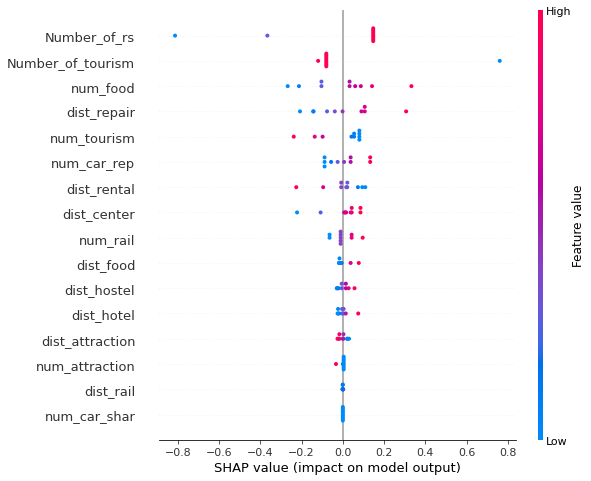

In [23]:
shap_values = shap.LinearExplainer(model, X).shap_values(X)
shap.summary_plot(shap_values, X,
                      max_display=25, auto_size_plot=True)

1) Feature importance: Variables are ranked in descending order.  
2) Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.  
3) Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.  
4) Correlation: A high level of the “alcohol” content has a high and positive impact on the quality rating.   
    The “high” comes from the red color, and the “positive” impact is shown on the X-axis.   
    Similarly, we will say “volatile acidity” is negatively correlated with the target variable.  

1) Важность признаков сверху вниз.  
2) На горизонтали показано влияние значение признака на величину прогноза.  
3) Красный цвет показывает высокое влияние на наблюдение, синий цвет низкое влияние на наблюдение.  
4) Высокое позитивное влияние - это если справа много красных точек.  

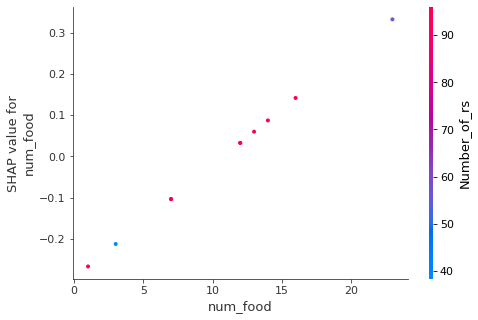

In [24]:
shap.dependence_plot("num_food", shap_values, X)

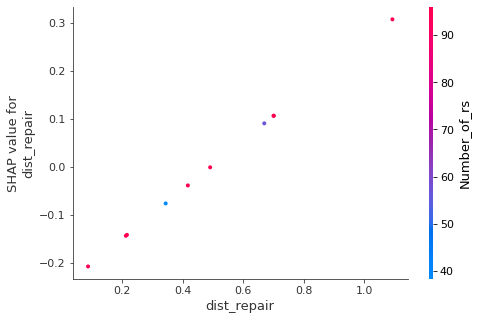

In [25]:
shap.dependence_plot("dist_repair", shap_values, X)

### Make submission

In [77]:
submission = pd.read_csv('data/sample_submission.csv')
submission['target'] = model.predict(X_valid.drop('point_id', axis=1))
submission.to_csv('data/MaryIzo_submission_4.csv', index=False)

In [79]:
my_submission = pd.read_csv('data/MaryIzo_submission_4x.csv')
my_submission[:20]

,point_id,target
0,F4lXR1cG,0.141668
1,4LJu4GTf,0.301788
2,kLuAAN3s,-0.261720
3,OxQHvaNu,-0.696787
4,paQsTa1K,0.464877
5,7x7uZwPc,-0.237026
6,tiPNVf91,-0.095353
7,OMCMewkC,0.479572
8,yCrOWDXH,-0.400662
9,eek3uK7b,-0.003002


In [81]:
my_submission = pd.read_csv('data/MaryIzo_submission_3.csv')
my_submission[:20]

,point_id,target
0,F4lXR1cG,-0.335979
1,4LJu4GTf,0.381474
2,kLuAAN3s,-0.491240
3,OxQHvaNu,-0.590162
4,paQsTa1K,0.123625
5,7x7uZwPc,0.097686
6,tiPNVf91,0.217830
7,OMCMewkC,-0.405423
8,yCrOWDXH,0.267192
9,eek3uK7b,0.257826
